In [10]:
#%matplotlib qt
%matplotlib inline
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
import torchtext
import torch.nn as nn
cmap = plt.get_cmap('viridis')
from mpl_toolkits.mplot3d import Axes3D

In [11]:
workdir = '/Users/stephane/Dropbox/Work/Codes/snips/automatic-data-generation/automatic_data_generation/'
dataroot = workdir + 'data/'
os.chdir(workdir)

# Exploring the vocabulary

In [12]:
from models.embedding import Datasets
datasets = Datasets(train_path=dataroot+'snips/train.csv', valid_path=dataroot+'snips/validate.csv', emb_dim=100, tokenizer='nltk')
vocab = datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
sos_idx = w2i['<sos>']
eos_idx = w2i['<eos>']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

In [13]:
i2w[:20]

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'the',
 'a',
 'to',
 '_object_type_',
 'for',
 '_object_name_',
 'in',
 '_playlist_',
 'i',
 'at',
 '_timerange_',
 '_rating_value_',
 '_artist_',
 'play',
 '_music_item_',
 'of']

# Karpathy CharRNN

### Temperature: 0.2

I want to book a reservation for a restaurant for a party of a party of 6 points

I want to book a reservation for a restaurant for a restaurant for a restaurant in Barken Marcha at a party of 6

I need a table for a restaurant for a party of a party of 6 points

### Temperature: 0.5
I need a table for a reservation for a restaurant in the area that serves find movement in the area at a party of a siming from now

I want to half album to Musaf Rock Story Barb playlist.

I want to give this current book The Very Satarora for the twenty-textbook.

### Temperature: 1.0
What will the weather be syar llind in Playlin Man.

Tell it i from the Shawnua Tf Hiss Morny Cimes

Hadon in a top-fight?

play the song from the fifties for ten in Mondital Maker

# Analyzing the runs

In [52]:
import torch
run = torch.load('run.pkl')

# Dynamics

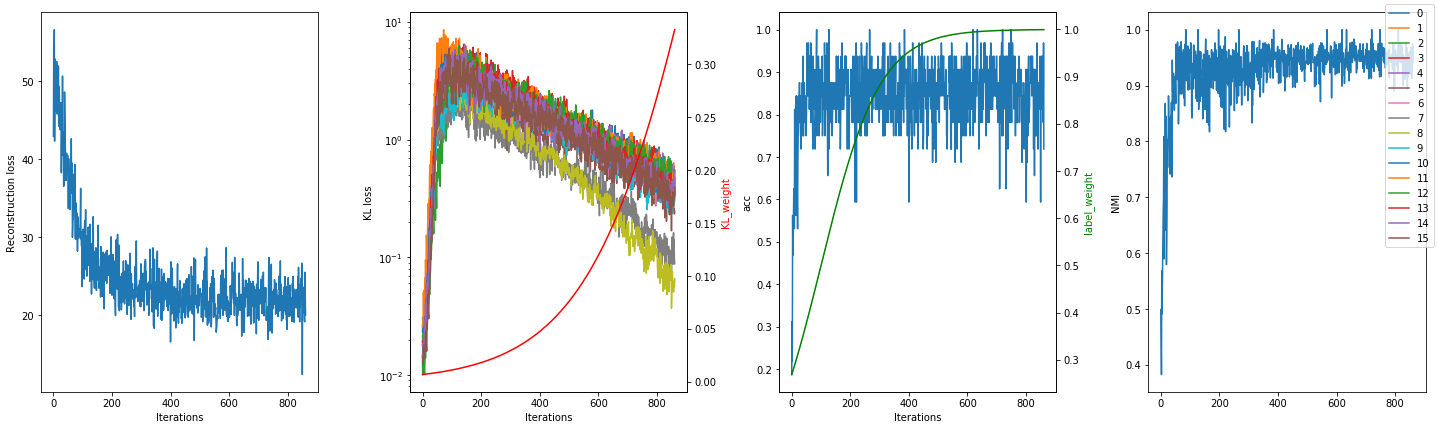

In [53]:
fig, axarr = plt.subplots(1,4, figsize=(20,6))
axarr = axarr.flatten()

args = run['args']
NLL_hist = run['NLL_hist']
KL_hist  = run['KL_hist' ]
NMI_hist = run['NMI_hist']
acc_hist = run['acc_hist']
t = np.array(range(len(NLL_hist)))

from train import anneal_fn
anneal_fn = np.vectorize(anneal_fn)
KL_weight = anneal_fn(args.anneal_function, t, args.k1, args.x1, args.m1)
label_weight = anneal_fn(args.anneal_function, t, args.k2, args.x2, args.m2)

KL_hist = np.array(KL_hist)
axarr[0].plot(t, NLL_hist )
for i in range(args.latent_size):
    axarr[1].semilogy(t, KL_hist[:,i], label=i)
ax1bis = axarr[1].twinx()
ax1bis.plot(t, KL_weight, color='red')
axarr[2].plot(t, acc_hist )
ax2bis = axarr[2].twinx()
ax2bis.plot(t, label_weight, color='green')
axarr[3].plot(t, NMI_hist)

for i in range(3):
    axarr[i].set_xlabel('Iterations')
axarr[0].set_ylabel('Reconstruction loss')
axarr[1].set_ylabel('KL loss')
ax1bis.set_ylabel('KL_weight', color='red')
axarr[2].set_ylabel('acc')
ax2bis.set_ylabel('label_weight', color='green')
axarr[3].set_ylabel('NMI')

fig.legend()
fig.tight_layout()
plt.show()

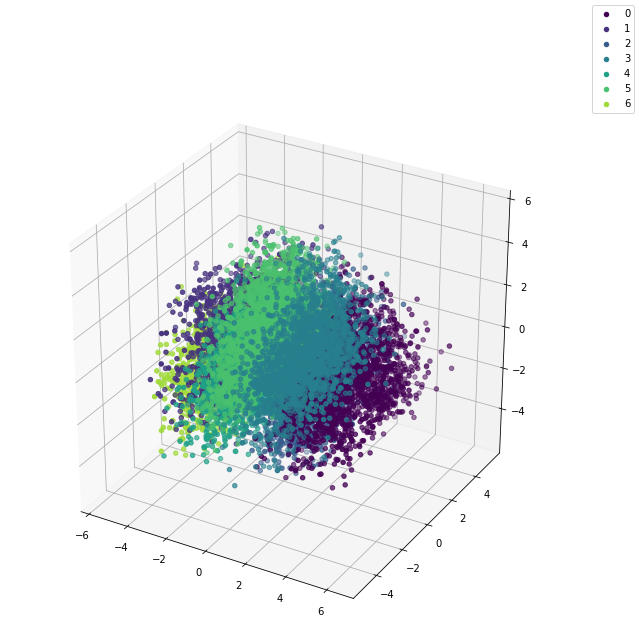

In [54]:
n_per_intent = 2000

latent = run['latent']
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
all_latent = sum([latent_list for latent_list in latent.values()], [])
pca.fit(all_latent)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for intent in latent.keys():
    points = pca.transform(latent[intent])
    #points = np.array(latent[intent])
    ax.scatter(points[:n_per_intent,0], points[:n_per_intent,1], points[:n_per_intent,2], c=[cmap(intent/len(latent.keys()))], label='{}'.format(intent))
fig.legend()
plt.show()

# Embeddings

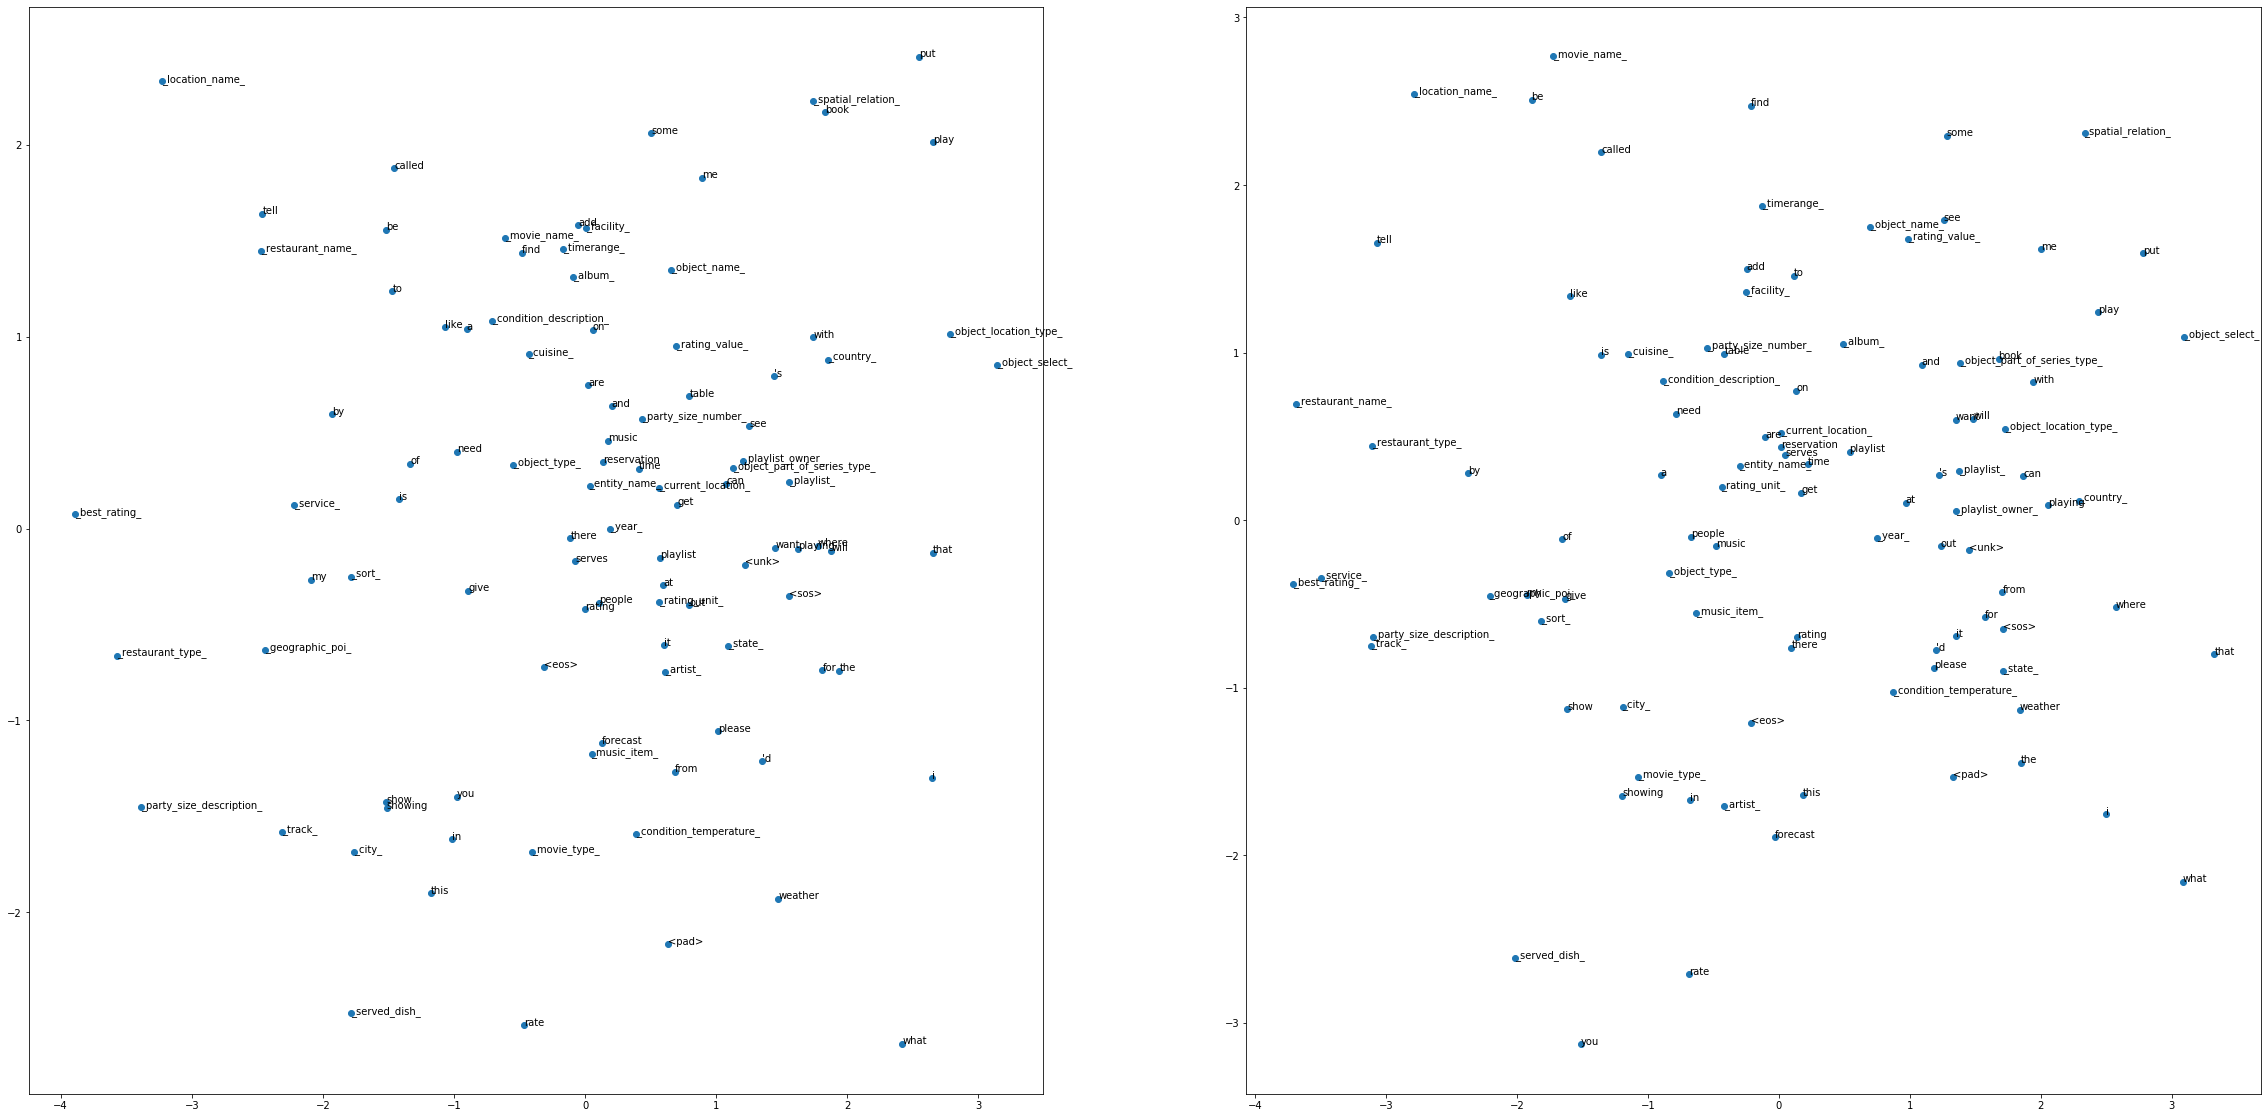

In [62]:
n_start = 0
n_end = 100
words = run['i2w']

fig, axarr = plt.subplots(1, 2, figsize=(40,20))
axarr = axarr.flatten()

from sklearn.decomposition import PCA
for ax, stage in enumerate(['before', 'after']):
    vectors = run['vectors'][stage]
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vectors)
    axarr[ax].scatter(proj[n_start:n_end,0], proj[n_start:n_end,1])
    for i, word in enumerate(words[n_start:n_end]):
        i += n_start
        axarr[ax].annotate(word,xy=(proj[i,0], proj[i,1]))

# Trajectories in latent space

In [56]:
from automatic_data_generation.models.embedding import Datasets
from automatic_data_generation.models.cvae import CVAE
from automatic_data_generation.utils.utils import to_device, interpolate, idx2word

run = torch.load('run.pkl')
args = run['args']

datadir = os.path.join('./data', args.dataset)
train_path = os.path.join(datadir, 'train.csv')
validate_path = os.path.join(datadir, 'validate.csv')
datasets = Datasets(train_path=os.path.join(train_path), valid_path=os.path.join(validate_path), emb_dim=args.emb_dim, tokenizer=args.tokenizer)

if args.input_type=='delexicalised':
    print('embedding the slots with %s averaging' %args.slot_averaging)
    datasets.embed_slots(args.slot_averaging)

vocab = datasets.TEXT.vocab if args.input_type=='utterance' else datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
i2int = datasets.INTENT.vocab.itos
int2i = datasets.INTENT.vocab.stoi
n_classes = len(i2int)
sos_idx = w2i['<sos>']
eos_idx = w2i['<eos>']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

model = CVAE(
        vocab_size=len(i2w),
        max_sequence_length=args.max_sequence_length,
        sos_idx=sos_idx,
        eos_idx=eos_idx,
        pad_idx=pad_idx,
        unk_idx=unk_idx,
        embedding_size=args.emb_dim,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        z_size=args.latent_size,
        n_classes=n_classes,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,
        temperature=args.temperature,
        conditional=False if args.conditional=='none' else True,
        bow=args.bow_loss
    )

state_dict = torch.load(args.pickle+'.pyT')
if state_dict['embedding.weight'].size(0) != model.embedding.weight.size(0): # vocab changed
    state_dict['embedding.weight'] = vocab.vectors
    state_dict['outputs2vocab.weight'] = torch.randn(len(i2w), args.hidden_size*model.hidden_factor)
    state_dict['outputs2vocab.bias'] = torch.randn(len(i2w))
model.load_state_dict(state_dict)

print('BLEU : ',run['bleu_scores'])
print('Diversity : ',run['diversity'])

embedding the slots with micro averaging
BLEU :  {'GetWeather': 0.30323122424880167, 'PlayMusic': 0.19586215938081752, 'BookRestaurant': 0.32858768451108805, 'SearchScreeningEvent': 0.21333938595031743, 'RateBook': 0.26549050441790006, 'SearchCreativeWork': 0.2449507463959256, 'AddToPlaylist': 0.21782391250858193, 'average': 0.2527550882019189}
Diversity :  0.30941286113699906


In [63]:
i2int

['GetWeather',
 'PlayMusic',
 'BookRestaurant',
 'SearchScreeningEvent',
 'RateBook',
 'SearchCreativeWork',
 'AddToPlaylist']

## Vary the continuous variable

In [60]:
intent = 2
interp_dim = 2
print(i2int[intent] + '\n')

#z1 = torch.randn([args.latent_size]).numpy()
#z2 = torch.randn([args.latent_size]).numpy()
z1 = torch.zeros([args.latent_size]).numpy()
z2 = torch.zeros([args.latent_size]).numpy()
z1[interp_dim] = -1
z2[interp_dim] = +1
z = to_device(torch.from_numpy(interpolate(start=z1, end=z2, steps=10)).float())
batch_size=z.size(0)

y_onehot = torch.zeros(batch_size, model.n_classes)
y = torch.LongTensor(batch_size,1).fill_(intent)
y_onehot.scatter_(1, y, 1)
samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

print('-------INTERPOLATION-------')
print(*idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>']), sep='\n')

BookRestaurant

-------INTERPOLATION-------
book a spot _restaurant_type_ that serves _served_dish_ <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book a reservation for _party_size_number_ people people <eos> <pad>
book reservations for _party_size_number_ people people <eos> <pad>
book reservations for _party_size_number_ people people <eos> <pad>


## Vary the discrete variable

In [61]:
z = torch.randn(model.n_classes,args.latent_size)

y_onehot = torch.zeros(model.n_classes, model.n_classes)
for i in range(model.n_classes):
    y_onehot[i,i] = 1

samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

for intent, sentence in enumerate(idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])):
    print(i2int[intent])
    print(sentence + '\n')

GetWeather
find the _object_type_ _object_name_ <eos> <pad>

PlayMusic
find me a reservation for _party_size_number_ people at _restaurant_name_ <eos> <pad>

BookRestaurant
i want to eat at _restaurant_name_ <eos> <pad>

SearchScreeningEvent
play some _genre_ music <eos> <pad>

RateBook
find the _object_type_ for _location_name_ <eos> <pad>

SearchCreativeWork
play some _genre_ music from _year_ <eos> <pad>

AddToPlaylist
i 'd like to hear some _genre_ music <eos> <pad>



In [ ]:
import torch
import numpy as np
target = torch.arange(0,5*64).view(64,-1)
bow = torch.randn((64,500))

loss = 0
for b, t in zip(bow, target):
    loss += torch.sum(b[t])
print(loss)
x = bow[:,target].view(64,64,)
print(x.size())
print(torch.einsum('iik->',(x)))
    #print(np.sum([b[idx].numpy() for idx in t]))